**GOAL OF THE NOTEBOOK:** Until now, we are just using random actions during training. This is obviously not the best approach as we train the model. Instead a better approach would be to understand how much should we explore and how much should we exploit.

It means that, initially we don't have any clue about the environment and it is important for the agent to explore and see how the environment is and where are the reward values and what are the paths to avoid.

As we train, we continue to get a better feel of the environment and we start to assign values to the states that are closer to the optimal values. So, we can also choose to exploit the learnings that we made along the way to create a good value-look up table.

So, we have to balance exploitation and exploration strategies to get the optimal results much efficient and faster.

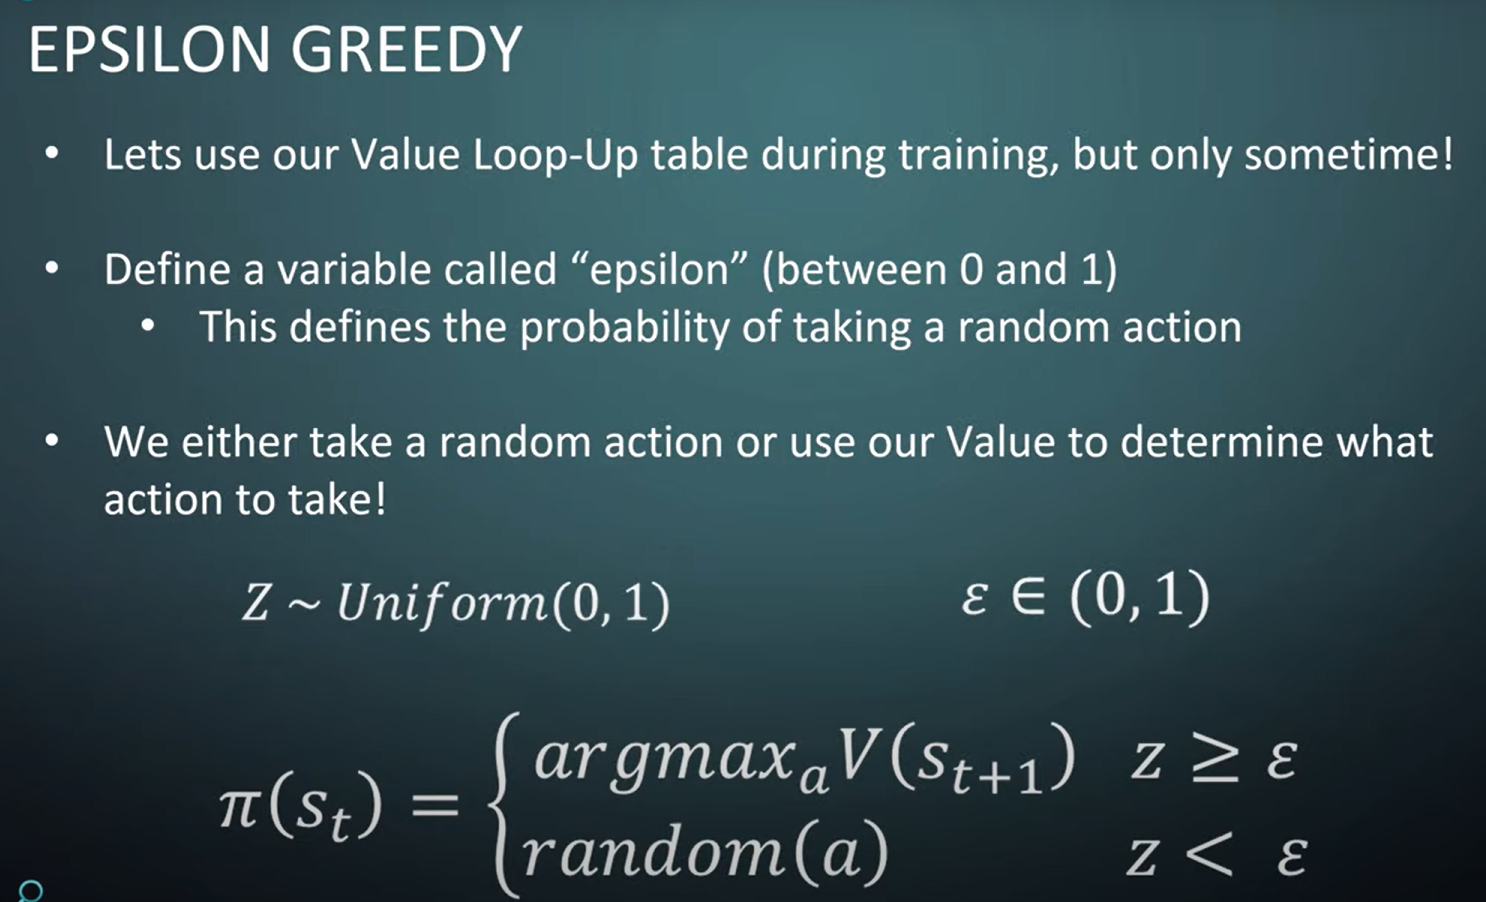

So, now the probability of taking a random action is no longer 100%. Some times, we use our value look up table to go to the state with the highest value.

# PROBLEM: GETTING TO THE GOAL STATE FROM THE INITIAL STATE BY AVOIDING PROBLEMS ALONG THE PATH USING **EPSILON-GREEDY STRATEGY**

We are making the rewards of certain grid cells negative to establish that the agent gets penalized to go into those grid cells and it should avoid them.

## Imports

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Reward function definition

In [23]:
rewards = np.zeros(16)
rewards[3] = 10 # HIGH POSITIVE REWARD
rewards[2] = -1 # NEGATIVE REWARDS
rewards[11] = -1
rewards[10] = -1


terminal_state = 3
state_values = np.zeros(16)

# alpha = 0.005
alpha = 0.02 # Our alpha value in this notebook is a lot larger than before, as we can see that the values in this new method are less noisy
# So, it would be good to affected by it a little more than the previous algorithm - > Monte carlo

epsilon = 0.3 # EPSILON GREEDY STRATEGY

score_log = []

In [24]:
rewards

array([ 0.,  0., -1., 10.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
        0.,  0.,  0.])

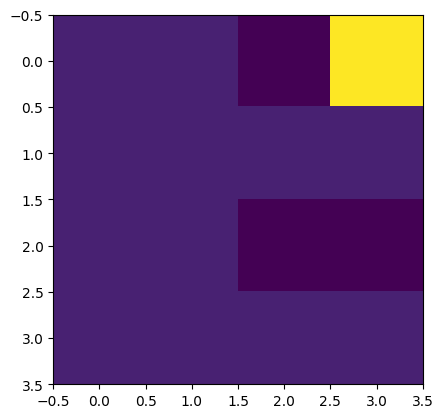

In [25]:
plt.imshow(rewards.reshape(4,4))

## State transition table

The following is our state transition table. We have 16 possible states in total from 0 to 15 and this table respresents how all the possible actions ie., Four actions 1 -> up, 2 -> right, 3 -> down, 4-> left affect the state transitions.

In [26]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Reinforcement_Learning_notebooks/Grid_world_example/state_transitions.csv"
state_transition_table = np.genfromtxt(file_path, delimiter=",").astype(int)

In [27]:
state_transition_table

array([[ 0,  1,  4,  0],
       [ 1,  2,  5,  0],
       [ 2,  3,  6,  1],
       [ 3,  3,  7,  2],
       [ 0,  5,  8,  4],
       [ 1,  6,  9,  4],
       [ 2,  7, 10,  5],
       [ 3,  7, 11,  6],
       [ 4,  9, 12,  8],
       [ 5, 10, 13,  8],
       [ 6, 11, 14,  9],
       [ 7, 11, 15, 10],
       [ 8, 13, 12, 12],
       [ 9, 14, 13, 12],
       [10, 15, 14, 13],
       [11, 15, 15, 14]])

In [28]:
state_transition_table[0]

array([0, 1, 4, 0])

## Estimating the returns using future state values.

We can see that in time-difference method, we don't need to compute the discounted rewards at all as we will not need all the returns of the entire trajectory.

This method involves taking state values from the future time steps and estimating values close to the average return values from the future time step.

In [29]:
def TD_update(next_val, values, rewards, states): # Takes in next value from the future time step, current values, rewards and states of current trajectory as arguments
    gamma = 0.9
    next_val = next_val
    #fixed bug in code here
    new_values = np.zeros(16) + values # Making a copy of the current values
    for i in reversed(range(len(rewards))): # From last reward to the first reward
        new_values[states[i]] = values[states[i]] + alpha * (rewards[i] + gamma * next_val - values[states[i]]) # Only changing the values corresponding to the current trajectory
        next_val = values[states[i]]
    return new_values

## Test agent (single trajectory)

test_agent() describes a single trajectory that happens during test time.

The entire work flow would be:
1. Have a reward function
2. Training: Set multiple trajectories and give returns values to every single trajectory. Also assign values to states based on the average values of rewards in each trajectory.
3. Test time: Now, we have values of all the states and we just traverse our test agent by selecting the next state with the highest value from the state transition matrix.

In [30]:
def test_agent():
    state = 12 #  Starting with Initial state
    done = False
    steps = 0
    total_rewards = 0
    states_log = []
    while (not(state == terminal_state)) and steps<30:
        states_log.append(state) # log the current state
        action = np.argmax(state_values[state_transition_table[state]]) # Choose the action that gets us into the state with highest value
        state = state_transition_table[state, action] # Updating state based on the action taken
        total_rewards += rewards[state]
        steps += 1
    states_log.append(state)
    return total_rewards, states_log # returns total rewards collected along the trajectory and a log of states and their transitions

## Training loop over multiple trajectories

We get returns grids for every single trajectory. A return grid is nothing but the return value of every cell in one trajectory. If we haven't touched that particular cell in the trajectory, the return grid's corresponding value to the respective cell would be 0.

In [31]:
number_of_trajectories = 1000
for _ in range(number_of_trajectories):
    state = 12 # Starting with the initial state
    state_log = [] # Initializing the state_log and reward_log values for the current trajectory
    reward_log = []
    steps = 0

    # This while logic to finish the current trajectory from the initial position to the goal state
    while (not(state == terminal_state)) and steps<40:
        reward_log.append(rewards[state])
        state_log.append(state)

        z = random.random() # Generates a random value between 0 and 1
        if z >=epsilon: # If random value is greater than epsilon -> EXPLOITATION ie., choosing next state with max value
            action = np.argmax(state_values[state_transition_table[state]])
        else:
            action = random.randint(0,3) # else -> EXPLORATION ie., random action

        state = state_transition_table[state, action]

        steps += 1

    # For the current trajectory, we have the rewardslog and states log values.
    # We are creating a return grid by using the cumulative discounted rewards function we have previously defined.
    reward_log.append(rewards[state])
    state_log.append(state)

    next_val = 0 # After, we reach the terminal state, we are making the next_val as 0

    # We don't need returns_log anymore
    # Let us directly update state values
    state_values = TD_update(next_val, state_values, reward_log, state_log)

    # Once, we get the returns_log of our current trajectory, we update the value-look up table by taking the average of current trajectory and previous ones.

    score_log.append(test_agent()[0]) # score is the reward that the test agent gets in the trajectory, which is nothing but cumulative rewards across the trajectory.

In [32]:
state_log # These are the state values at the respective time steps in the final trajectory

[12, 8, 4, 5, 9, 5, 6, 7, 3]

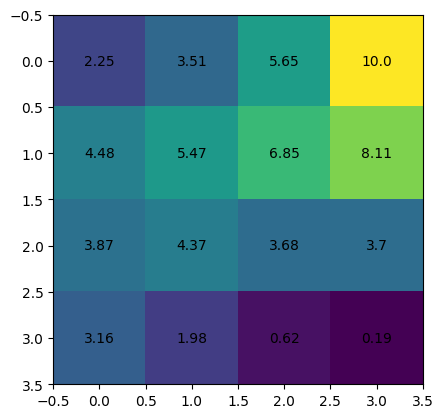

In [33]:
fig1, ax1= plt.subplots(1)
ax1.imshow(state_values.reshape(4, 4))

for (j,i), label in np.ndenumerate(state_values.reshape(4, 4).round(2)):
    ax1.text(i,j,label,ha='center',va='center')

We can observe that the states closer to the goal state have higher values and the states farther away have lower values.

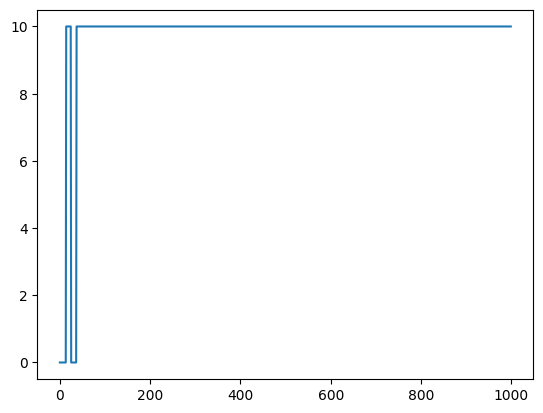

In [34]:
plt.plot(score_log)

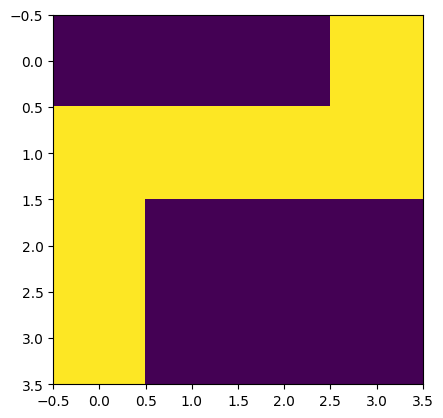

In [35]:
_, state_log = test_agent() # state_log stores the states visited by the test_agent()
state_view = np.zeros(16) # Initializing a state_view array to view the states visited by the test agent
state_view[state_log] = 1 # Setting the value of the states visited by the test agent as 1
plt.imshow(state_view.reshape(4,4))

In [36]:
state_transition_table[12]

array([ 8, 13, 12, 12])

In [37]:
state_values[state_transition_table[12]]
# Values of the four states, we have assigned from the returns_log array collected over multiple trajectories

array([3.86664014, 1.98181288, 3.16427428, 3.16427428])